# Spatio-temporal clustering

In [1]:
# le classique imports
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import geopandas
import geoplot
from shapely.geometry import Polygon, Point
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import geoplot.crs as gcrs
import matplotlib as mpl
import matplotlib.colors as colors

pd.set_option('mode.chained_assignment', None)

# Definitions
## Paths and variables

In [2]:
path = 'C:/Users/Zaca/Documents/Datasets/nyc/'

## Plotting functions

In [51]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100, reverse=False):
   
    if reverse:
        new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(maxval, minval, n))) 
        
        arr = np.linspace(0, 50, 100).reshape((10, 10))
        fig, ax = plt.subplots(ncols=2)
        ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
        ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
        plt.show()
                
        return new_cmap
   
    else:
        new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
        
        arr = np.linspace(0, 50, 100).reshape((10, 10))
        fig, ax = plt.subplots(ncols=2)
        ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
        ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
        plt.show()
        
        return new_cmap
    
def default_plot(ax, spines): 
    
    ax = plt.gca()
    # Remove unnecessary axes and ticks (top and bottom)
    ax.spines["top"].set_visible(False)   
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    # Set the ticks facing OUTWARD
    ax.get_yaxis().set_tick_params(direction='out')
    ax.get_xaxis().set_tick_params(direction='out')
    
    # Remove grid
    #ax.grid('off')
    
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
        
    if 'right' in spines:
        ax.yaxis.set_ticks_position('right')

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')

    return ax
    
def get_colors(cmap, n):
    cmap = mpl.cm.get_cmap(cmap)
    rgba = [cmap(x) for x in np.linspace(0.01, 0.99, n)]
    sns.palplot(sns.color_palette(rgba));    
    return rgba

def get_single_color(cmap, n):
    cmap = mpl.cm.get_cmap(cmap)
    rgba = cmap(n)
    return rgba

def precinct_selected(precinct, basemap): 
    plt.title(str(precinct))
    basemap['selected'] = np.where(basemap.precinct == precinct, 1, 0)   
    ax = geoplot.choropleth(basemap, hue='selected', figsize=(8, 8), lw= 1, edgecolor='k', alpha=1, cmap=new_cmap, projection=gcrs.AlbersEqualArea())
    #geoplot.polyplot(basemap[basemap.precinct == precinct], lw=1, facecolor= get_single_color(new_cmap, .99), edgecolor='k', alpha=1)

def view_clusters(basemap, labeled_data):
    ax = geoplot.polyplot(basemap[basemap.precinct == labeled_data.precinct.values[0]], figsize=(8, 8), lw= 2, facecolor= 'None', edgecolor='k', alpha=1)  
    for i in range(len(labeled_data.labels.unique())):
        ax.scatter(labeled_data[labeled_data.labels == i]['longitude'], labeled_data[labeled_data.labels == i]['latitude'], color=cluster_colors[i], alpha=.75, s=100)
        
def temporal_distribution(labeled_data):   
    fig, ax = plt.subplots(figsize=(6,4))
    ax = default_plot(ax, ['left', 'bottom'])
    plt.xlabel('Time of Day')
    plt.ylabel('Density')
    plt.xlim(0, 24)
    
    min_time = []
    max_time = []
    
    for i in range(len(labeled_data.labels.unique())):
        sns.kdeplot(labeled_data[labeled_data.labels == i].time, bw=1.5, color=cluster_colors[i], label=str(i+1), lw=3)
        
        min_calc = np.quantile(labeled_data[labeled_data.labels == i].time, .5) - 4
        max_calc = np.quantile(labeled_data[labeled_data.labels == i].time, .5) + 4
        
        if min_calc < 0:
            min_calc = 24 + min_calc
        
        if max_calc > 24:
            max_calc = max_calc - 24
            
        min_time += [min_calc]
        max_time += [max_calc]
        
        print('Cluster ' + str(i) + ' schedule:', min_calc, max_calc)
    
    return list(zip(min_time, max_time))

## Algorithm functions

In [33]:
def make_contour(longitude, latitude, precinct_polygon, colors, levels):
    
    x = longitude
    y = latitude
    
    # check bounds
    xmin = precinct_polygon.bounds['minx'].values - 0.0025
    xmax = precinct_polygon.bounds['maxx'].values + 0.0025
    ymin = precinct_polygon.bounds['miny'].values - 0.0025
    ymax = precinct_polygon.bounds['maxy'].values + 0.0025
    
    # Create meshgrid
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    cset = plt.contour(xx, yy, f, colors=colors, levels=levels, linewidths=1.5)
    
    return cset


def get_level(contour, n):
    
    # the n gives you the level
    # just remember that its backwards
    # the outermost level is 0
    
    x = []
    y = []
    for j in range(len(contour.allsegs)):
        for ii, seg in enumerate(contour.allsegs[j]):
            x += [seg[:,0]]
            y += [seg[:,1]]
    
    return list(zip(x[n], y[n]))  


def get_view_contours(basemap, labeled_data, precinct, levels):
    
    fig, ax = plt.subplots()
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    contours = []
    for i in range(len(labeled_data.labels.unique())):
        ctr = make_contour(labeled_data[labeled_data.labels == i]['longitude'], labeled_data[labeled_data.labels == i]['latitude'], basemap[basemap.precinct == labeled_data.precinct.values[0]]['geometry'], colors=cluster_colors[i], levels=levels)
        contours += [ctr]

    levels = [get_level(x, 0) for x in contours]

    ax = geoplot.polyplot(basemap[basemap.precinct == labeled_data.precinct.values[0]], figsize=(8, 8), lw= 2, facecolor= 'None', edgecolor='k', alpha=1)
    for i in range(len(labeled_data.labels.unique())):
        ax.scatter(labeled_data[labeled_data.labels == i]['longitude'], labeled_data[labeled_data.labels == i]['latitude'], color=cluster_colors[i], alpha=.5, s=100)
        ax.plot([x[0] for x in levels[i]], [x[1] for x in levels[i]], color=cluster_colors[i], lw=3)
        
    return levels


def make_clusters(data, n):
    
    data = data[['latitude', 'longitude', 'time']]
    stdscaler = StandardScaler()
    features = stdscaler.fit_transform(data)
    #cluster = KMeans(n)
    cluster = AgglomerativeClustering(n)
    model = cluster.fit(features)
    
    # re-label so that cluster 0 is always the largest and so on.
    data['labels'] = model.labels_
    re_labeling = data.labels.value_counts().reset_index()['index']
    data['new_labels'] = data['labels'].replace(list(re_labeling.values), list(re_labeling.index))
    
    print('Cluster sizes:')
    print(data.new_labels.value_counts())
    
    return data.new_labels.values


def main(ds, training_period, precinct, n_clusters, testing_period, n_levels=3):
    
    subselection = ds[(ds.date > training_period[0]) & (ds.date < training_period[1]) & (ds.precinct == precinct)]
    subselection['labels'] = make_clusters(subselection, n_clusters)
    precinct_selected(precinct, clean_map)
    view_clusters(clean_map, subselection)
    time_windows = temporal_distribution(subselection)
    contours = get_view_contours(clean_map, subselection, precinct=precinct, levels=n_levels)
    
    zones = [Polygon(x) for x in contours]
    start_time = [x[0] for x in time_windows]
    end_time = [x[1] for x in time_windows]
    
    test_selection = ds[(ds.date > testing_period[0]) & (ds.date < testing_period[1]) & (ds.precinct == precinct)][['latitude', 'longitude', 'time']].reset_index(drop=True)
    test_points = [Point(x, y) for x, y in list(zip(test_selection.longitude, test_selection.latitude))]
    test_times = list(test_selection.time.values)
    
    landed = 0
    for cluster in range(n_clusters):
        for test in range(len(test_points)):
            if (test_points[test].within(zones[cluster])) and (start_time[cluster] <= test_times[test] <= end_time[cluster]):
                landed += 1
                
    if len(test_points) > 0:         
        score = landed/len(test_points)
    else:
        score = 0
    print('Precinct:', precinct)
    print('Burglaries located:', score*100)
    
    return score

# Choosing colors

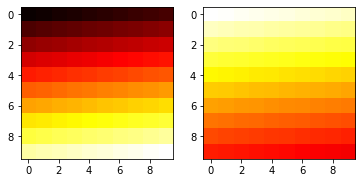

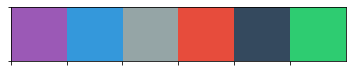

In [6]:
cmap = plt.get_cmap('hot')
new_cmap = truncate_colormap(cmap, 0.35, 1, reverse=True)

#cluster_colors = get_colors(cmap='cool_r', n=4)
#cluster_colors = ["#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
cluster_colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.palplot(sns.color_palette(cluster_colors));

# Preparing base maps

In [7]:
# open shapefile
pcints = geopandas.read_file(path + 'nypd_precincts.shp').to_crs(epsg=4326)

# clean a variable dtypes
pcints['pct'] = pcints['pct'].astype('int32')

# create a new, clean GeoDataFrame
clean_map = geopandas.GeoDataFrame()
clean_map['precinct'] = pcints['pct'].unique()
clean_map['geometry'] = [Polygon(max(pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union, key=lambda a: a.area).exterior) if pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union.geom_type == 'MultiPolygon' else Polygon(pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union.exterior) for pct in clean_map.precinct]

# Read pre-processed data

In [8]:
# open data
crime = pd.read_csv(path + 'nypd_historic_07-18.csv', index_col=0)
# transform to datetime
crime['date'] = pd.to_datetime(crime['date'])

C:\Users\Zaca\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Filter by crime

In [43]:
violent = ['FELONY ASSAULT', 'ROBBERY']
propert = ['BURGLARY', 'ARSON', 'GRAND LARCENY', 'GRAND LARCENY OF MOTOR VEHICLE']
crime_filter = violent + propert
crime_subset = crime[crime.description.isin(crime_filter)]

# Select crime type

In [44]:
ds = crime_subset[(crime_subset.description == violent[1])] # & (crime.premises.str.contains(loc))]

# look at number of crime per precinct for exploration
highest_ = ds.groupby('precinct').agg(count=('date', 'count')).sort_values(by='count', ascending=False)

# Select algorithm parameters

In [53]:
precinct = 110
training_period = ['2017-10-01', '2017-12-31']
testing_period = ['2018-01-01', '2018-01-31']
n_clusters = 3
n_levels = 3 # how restrictive are the clusters

training = ds[(ds.date > training_period[0]) & (ds.date < training_period[1]) & (ds.precinct == precinct)]
test = ds[(ds.date > testing_period[0]) & (ds.date < testing_period[1]) & (ds.precinct == precinct)][['latitude', 'longitude', 'time']].reset_index(drop=True)
test_points = [Point(x, y) for x, y in list(zip(test.longitude, test.latitude))]
test_times = list(test.time.values)

# Debugging section

Cluster sizes:
0    27
1    24
2    18
Name: new_labels, dtype: int64
Cluster 0 schedule: 14.0 22.0
Cluster 1 schedule: 5.5 13.5
Cluster 2 schedule: 0.0 8.0
Precinct: 110
Burglaries located: 47.61904761904761


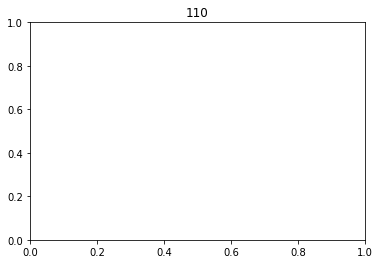

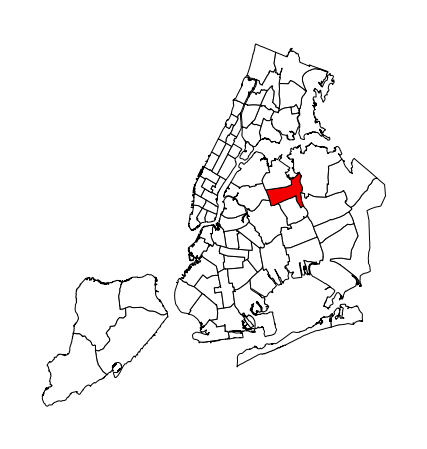

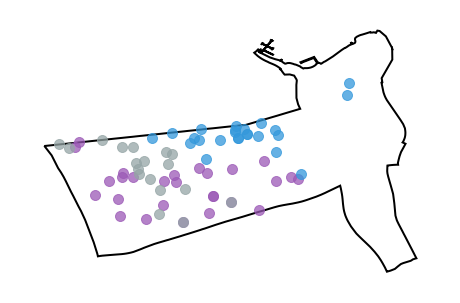

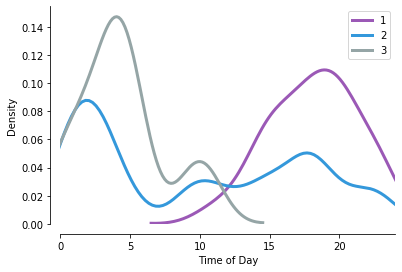

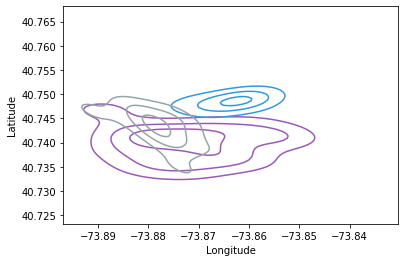

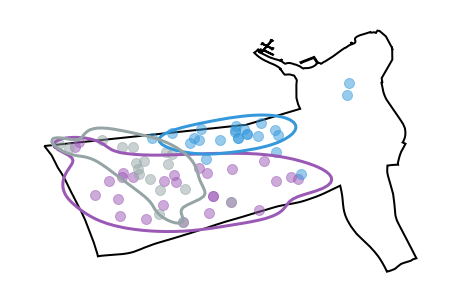

In [54]:
# define and select clustering algorithm
training['labels'] = make_clusters(training, n_clusters)

# showing selected area
precinct_selected(precinct, clean_map)

# view clusters identified by training
view_clusters(clean_map, training)

# temporal distribution of clusters
time_windows = temporal_distribution(training)

# estimate kernel density and grab contours
contours = get_view_contours(clean_map, training, precinct, levels=n_levels)

# define clusters
zones = [Polygon(x) for x in contours]
start_time = [x[0] for x in time_windows]
end_time = [x[1] for x in time_windows]

landed = 0
for cluster in range(n_clusters):
    for test in range(len(test_points)):
        if (test_points[test].within(zones[cluster])) and (start_time[cluster] <= test_times[test] <= end_time[cluster]):
            landed += 1
                
if len(test_points) > 0:         
    score = landed/len(test_points)
else:
    score = -1

print('Precinct:', precinct)
print('Burglaries located:', score*100)

# For every precinct

In [49]:
# get list of precincts
precincts = list(highest_.index[:25])

Cluster sizes:
0    72
1    52
2    45
Name: new_labels, dtype: int64
Cluster 0 schedule: 14.0 22.0
Cluster 1 schedule: 14.0 22.0
Cluster 2 schedule: 23.0 7.0
Precinct: 75
Burglaries located: 42.5531914893617
Cluster sizes:
0    66
1    25
2    17
Name: new_labels, dtype: int64
Cluster 0 schedule: 13.0 21.0
Cluster 1 schedule: 0.0 8.0
Cluster 2 schedule: 8.0 16.0
Precinct: 43
Burglaries located: 45.83333333333333
Cluster sizes:
0    50
1    25
2    15
Name: new_labels, dtype: int64
Cluster 0 schedule: 13.5 21.5
Cluster 1 schedule: 12.0 20.0
Cluster 2 schedule: 2.0 10.0
Precinct: 73
Burglaries located: 56.25
Cluster sizes:
0    31
1    30
2    29
Name: new_labels, dtype: int64
Cluster 0 schedule: 13.0 21.0
Cluster 1 schedule: 23.0 7.0
Cluster 2 schedule: 15.0 23.0
Precinct: 52
Burglaries located: 50.0
Cluster sizes:
0    53
1    50
2    23
Name: new_labels, dtype: int64
Cluster 0 schedule: 12.0 20.0


C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Cluster 1 schedule: 5.0 13.0
Cluster 2 schedule: 0.0 8.0
Precinct: 40
Burglaries located: 53.125


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)


Cluster sizes:
0    38
1    23
2    20
Name: new_labels, dtype: int64
Cluster 0 schedule: 15.0 23.0
Cluster 1 schedule: 0.0 8.0
Cluster 2 schedule:

C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, 

 7.5 15.5
Precinct: 44
Burglaries located: 60.86956521739131
Cluster sizes:
2    25
1    25
0    25
Name: new_labels, dtype: int64


C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much m

Cluster 0 schedule: 13.0 21.0
Cluster 1 schedule: 13.0 21.0
Cluster 2 schedule: 3.0 11.0
Precinct: 67
Burglaries located: 28.000000000000004
Cluster sizes:
0    60
1    33
2    22
Name: new_labels, dtype: int64


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, se

Cluster 0 schedule: 14.0 22.0
Cluster 1 schedule: 1.0 9.0
Cluster 2 schedule: 17.0 1.0
Precinct: 47
Burglaries located: 33.33333333333333
Cluster sizes:
0    59
2    22
1    22
Name: new_labels, dtype: int64
Cluster 0 schedule: 9.0 17.0
Cluster 1 schedule: 14.5 22.5
Cluster 2 schedule: 22.5 6.5


C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, 

Precinct: 46
Burglaries located: 39.130434782608695
Cluster sizes:
0    37
1    35
2    21
Name: new_labels, dtype: int64
Cluster 0 schedule: 

C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)


13.0 21.0
Cluster 1 schedule: 10.0 18.0
Cluster 2 schedule: 23.0 7.0
Precinct: 103
Burglaries located: 41.935483870967744
Cluster sizes:
0    52
1    22
2    12
Name: new_labels, dtype: int64
Cluster 0 schedule: 11.5 19.5
Cluster 1 schedule: 15.0 23.0

C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



Cluster 2 schedule: 22.0 6.0
Precinct: 79
Burglaries located: 26.923076923076923
Cluster sizes:
0    29
1    28
2    19
Name: new_labels, dtype: int64


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, se

Cluster 0 schedule: 15.0 23.0
Cluster 1 schedule: 0.0 8.0
Cluster 2 schedule: 13.0 21.0


C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much m

Precinct: 83
Burglaries located: 52.0
Cluster sizes:
0    31
1    25
2    18
Name: new_labels, dtype: int64
Cluster 0 schedule: 8.0 16.0
Cluster 1 schedule: 4.0 12.0
Cluster 2 schedule: 15.0 23.0


C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much m

Precinct: 48
Burglaries located: 36.0
Cluster sizes:
0    24
1    18
2    10
Name: new_labels, dtype: int64
Cluster 0 schedule: 11.0 19.0
Cluster 1 schedule: 23.5 7.5
Cluster 2 schedule: 16.0 24.0


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, se

Precinct: 70
Burglaries located: 50.0
Cluster sizes:
0    35
1    25
2    12
Name: new_labels, dtype: int64
Cluster 0 schedule: 23.0 7.0
Cluster 1 schedule: 15.0 23.0
Cluster 2 schedule: 1.0 9.0


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, se

Precinct: 115
Burglaries located: 42.857142857142854
Cluster sizes:
0    27
1    24
2    18
Name: new_labels, dtype: int64


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Cluster 0 schedule: 14.0 22.0
Cluster 1 schedule: 5.5 13.5
Cluster 2 schedule: 0.0 8.0
Precinct: 110
Burglaries located: 47.61904761904761
Cluster sizes:
0    30
1    24
2     7
Name: new_labels, dtype: int64


C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much m

Cluster 0 schedule: 11.5 19.5
Cluster 1 schedule: 15.0 23.0
Cluster 2 schedule: 23.0 7.0
Precinct: 81
Burglaries located: 36.0
Cluster sizes:

C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much m


0    17
1    16
2    14
Name: new_labels, dtype: int64
Cluster 0 schedule: 11.0 19.0
Cluster 1 schedule: 23.0 7.0
Cluster 2 schedule: 14.0 22.0


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, se

Precinct: 90
Burglaries located: 41.66666666666667
Cluster sizes:
0    27
1    15
2    14
Name: new_labels, dtype: int64
Cluster 0 schedule: 13.0 21.0
Cluster 1 schedule: 22.0 6.0
Cluster 2 schedule: 8.5 16.5


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, se

Precinct: 113
Burglaries located: 75.0
Cluster sizes:
0    24
1    22
2    12
Name: new_labels, dtype: int64
Cluster 0 schedule: 10.5 18.5
Cluster 1 schedule: 13.5 21.5
Cluster 2 schedule: 21.5 5.5


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_wa

Precinct: 42
Burglaries located: 47.61904761904761
Cluster sizes:
0    23
1    21
2     3
Name: new_labels, dtype: int64


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_wa

Cluster 0 schedule: 11.0 19.0
Cluster 1 schedule: 14.0 22.0
Cluster 2 schedule: 23.0 7.0
Precinct: 105
Burglaries located: 40.0
Cluster sizes:
0    33
1     9
2     6
Name: new_labels, dtype: int64


C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, 

Cluster 0 schedule: 12.0 20.0
Cluster 1 schedule: 0.0 8.0
Cluster 2 schedule: 13.0 21.0
Precinct: 77
Burglaries located: 18.181818181818183
Cluster sizes:
0    26
1    23
2    16
Name: new_labels, dtype: int64


C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, 

Cluster 0 schedule: 12.0 20.0
Cluster 1 schedule: 8.0 16.0
Cluster 2 schedule: 6.5 14.5
Precinct: 71
Burglaries located: 23.076923076923077
Cluster sizes:
0    20
2    17
1    17
Name: new_labels, dtype: int64


C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much m

Cluster 0 schedule: 14.5 22.5
Cluster 1 schedule: 0.0 8.0
Cluster 2 schedule: 11.0 19.0
Precinct: 114
Burglaries located: 33.33333333333333
Cluster sizes:
0    24
1    20
2    17
Name: new_labels, dtype: int64


C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much m

Cluster 0 schedule: 14.5 22.5
Cluster 1 schedule: 12.0 20.0
Cluster 2 schedule: 23.0 7.0
Precinct: 106
Burglaries located: 41.17647058823529


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)


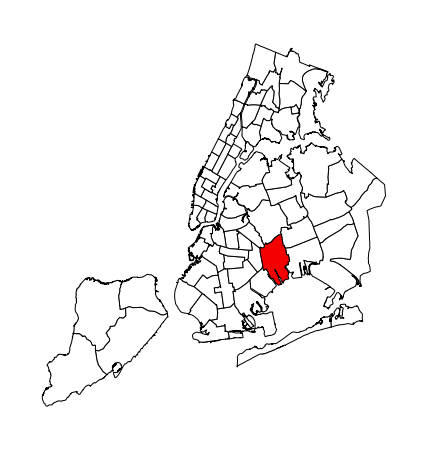

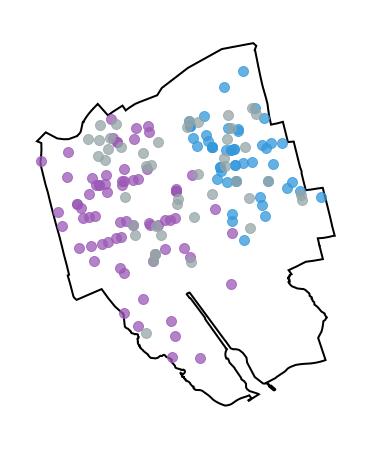

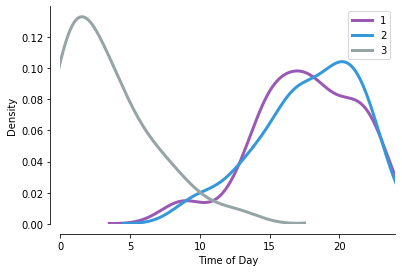

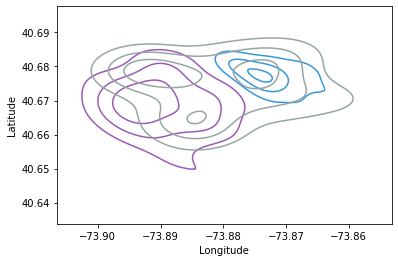

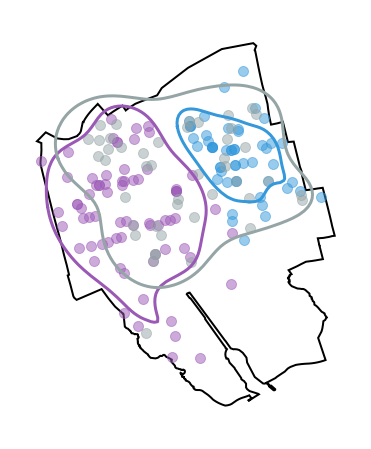

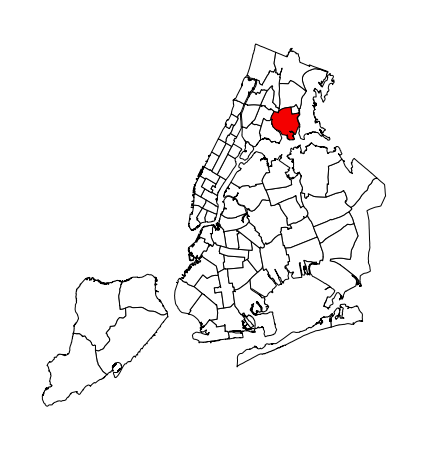

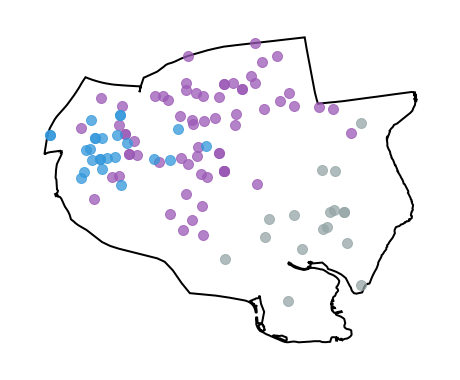

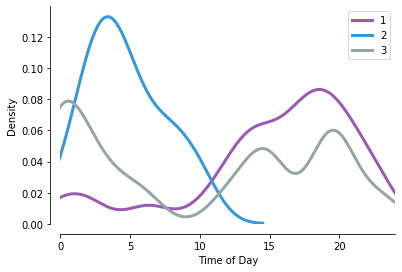

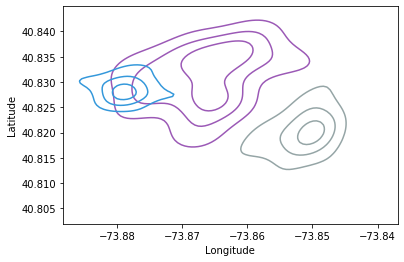

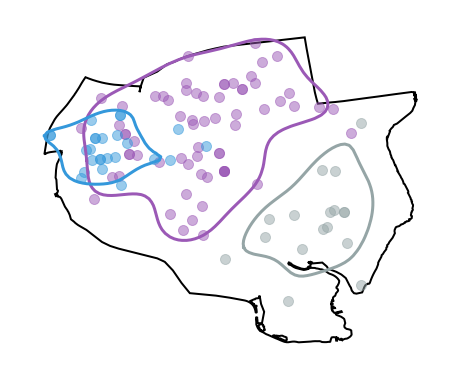

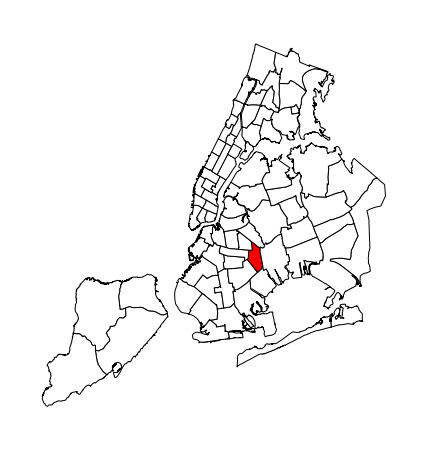

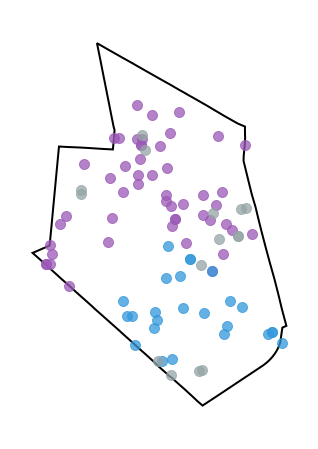

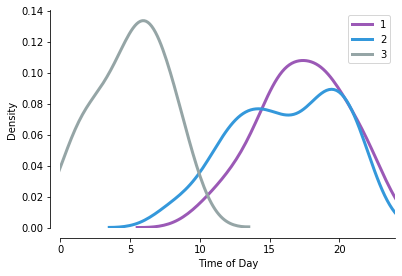

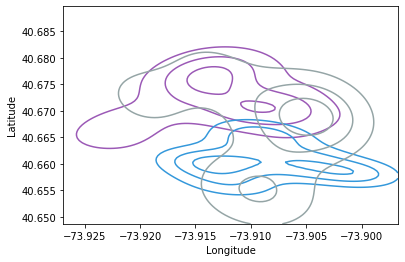

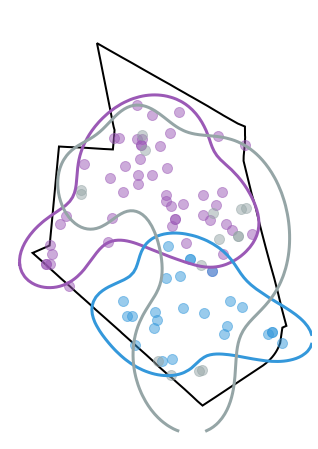

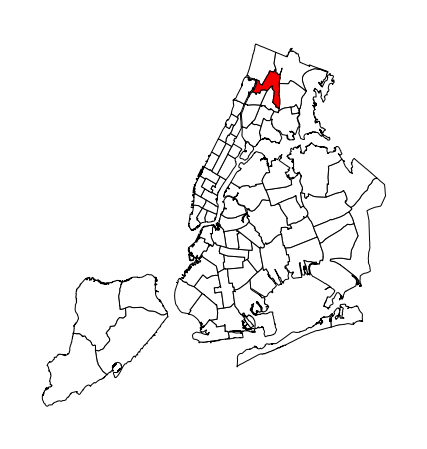

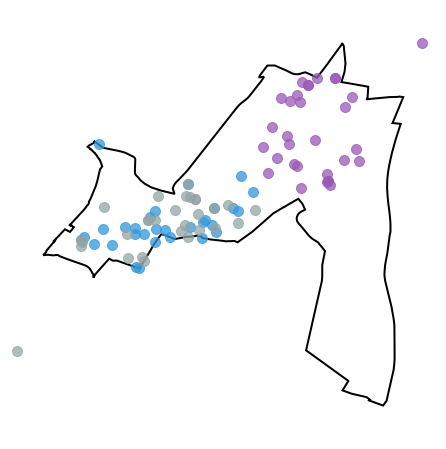

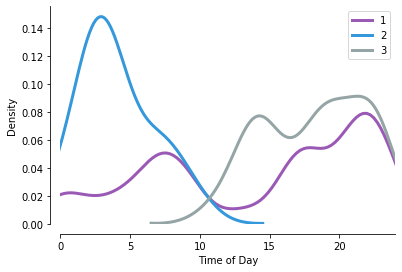

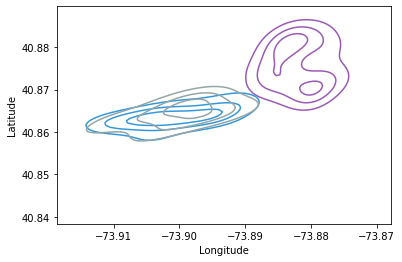

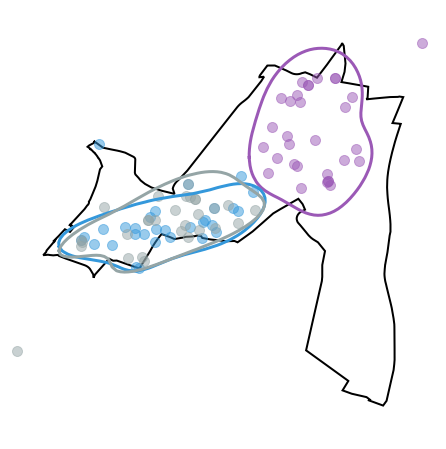

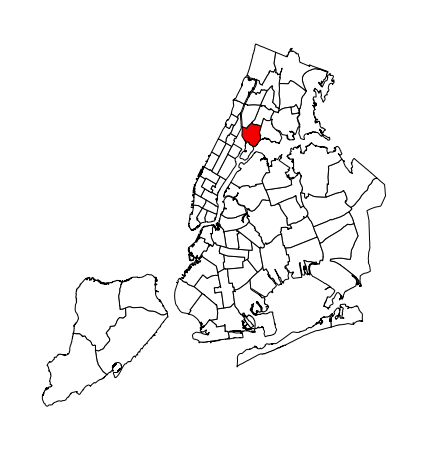

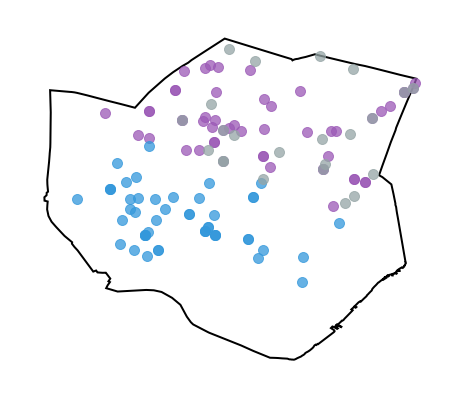

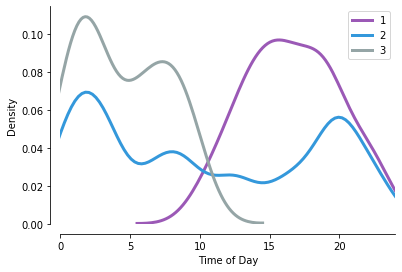

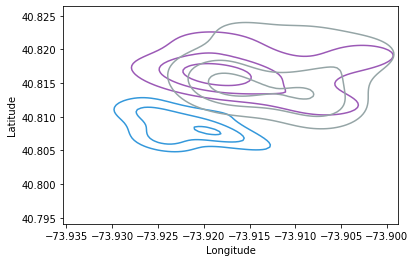

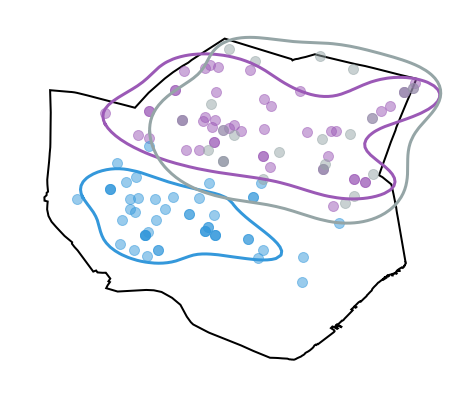

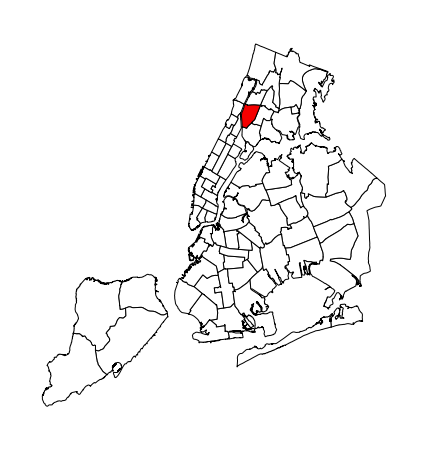

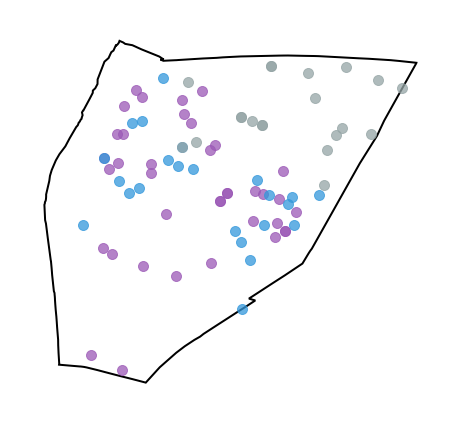

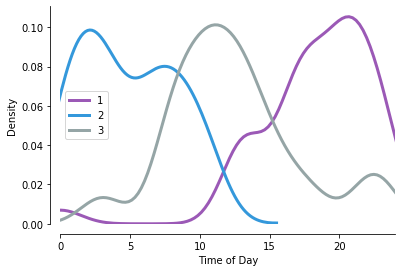

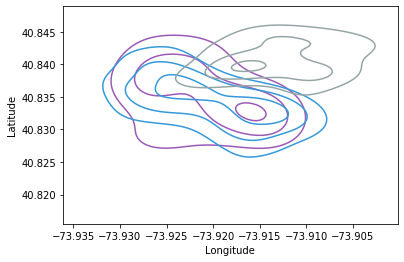

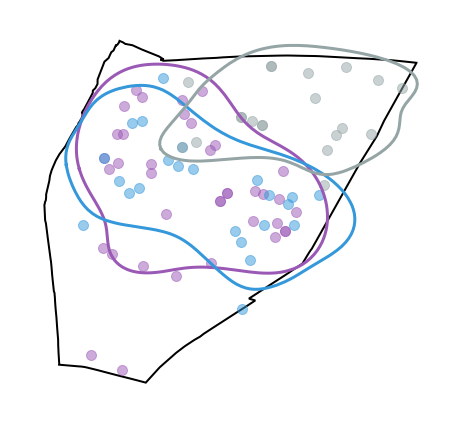

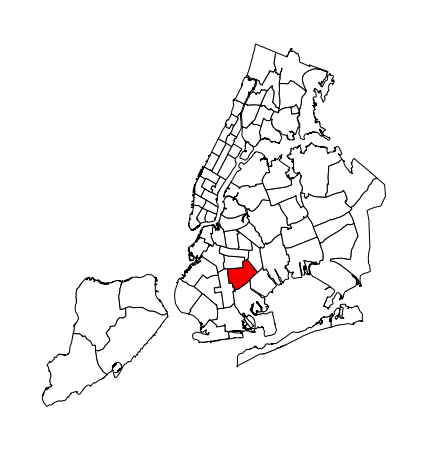

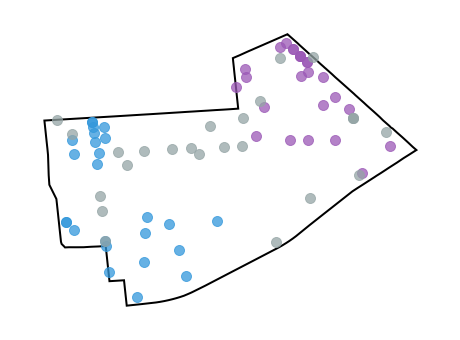

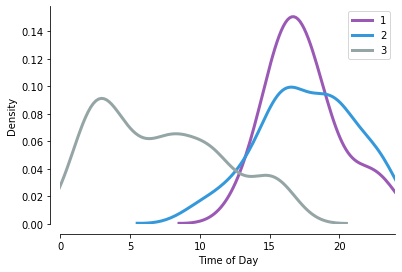

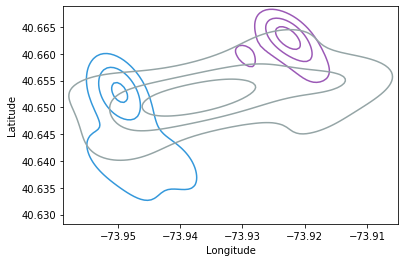

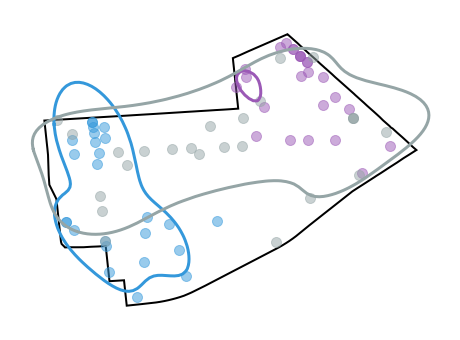

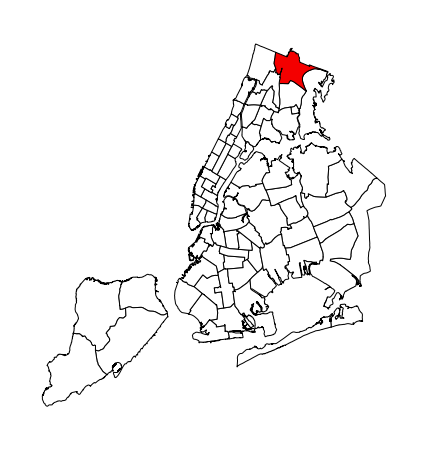

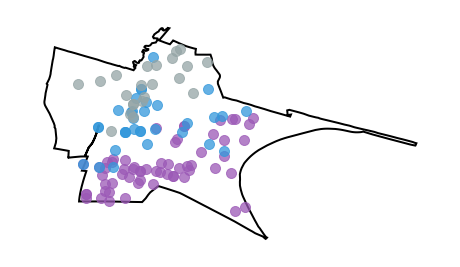

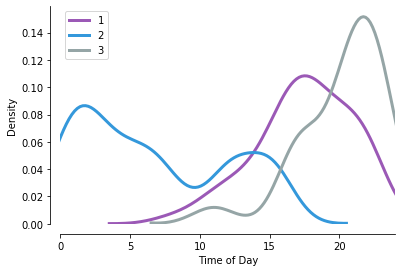

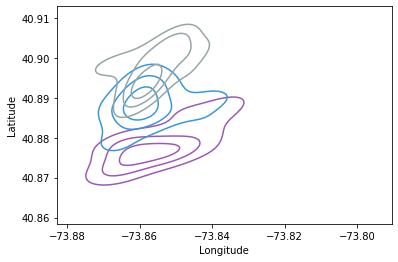

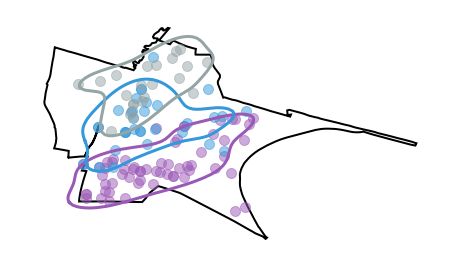

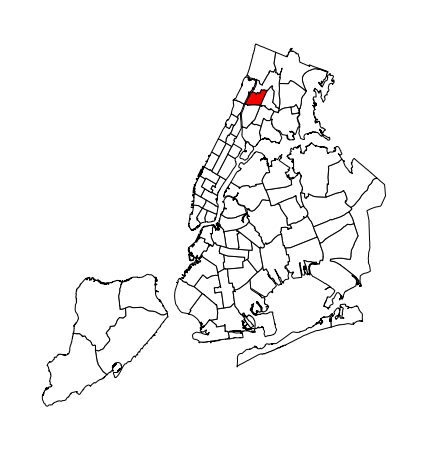

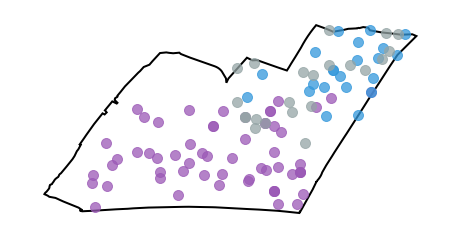

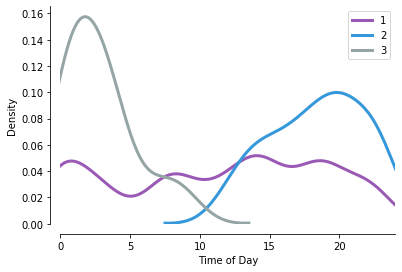

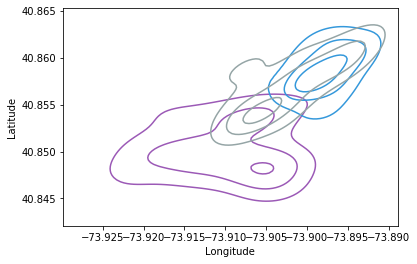

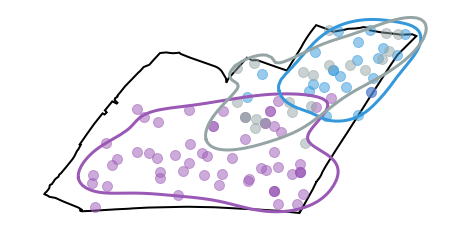

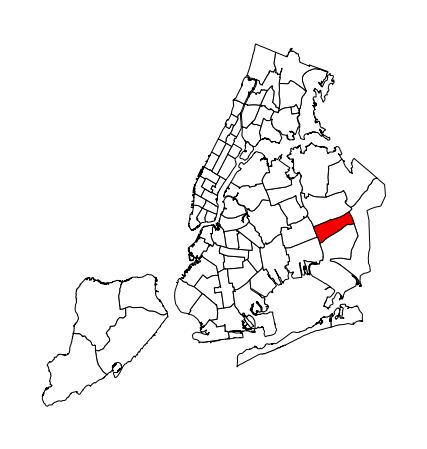

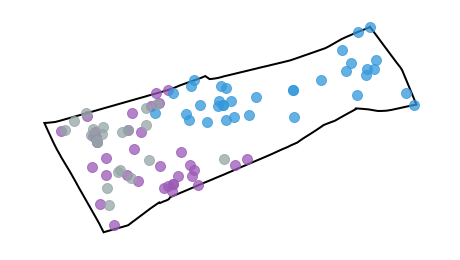

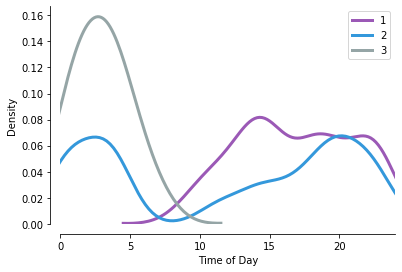

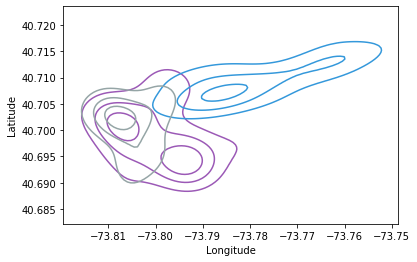

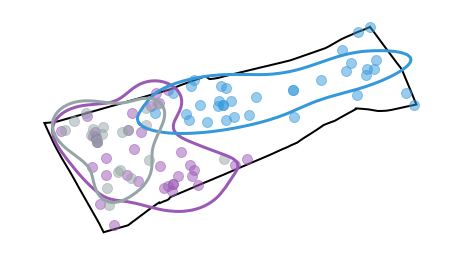

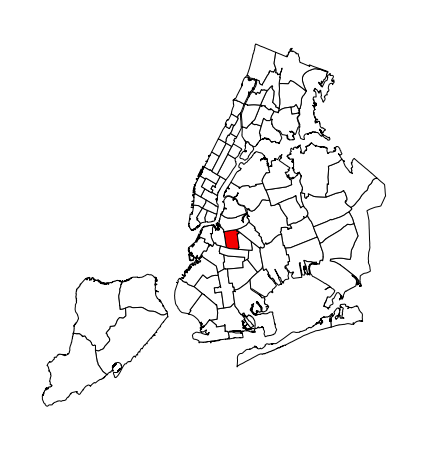

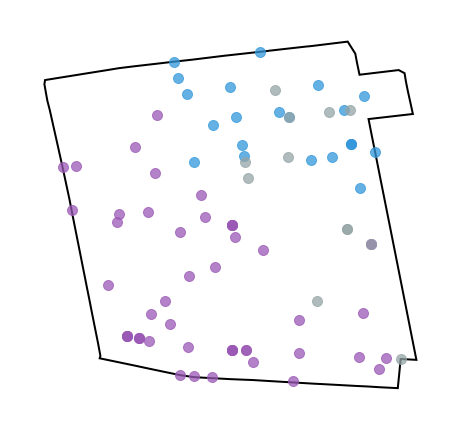

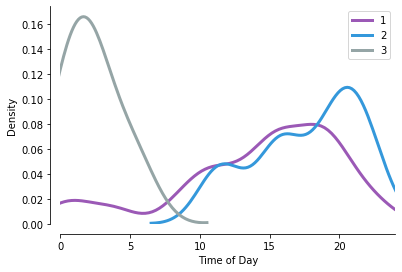

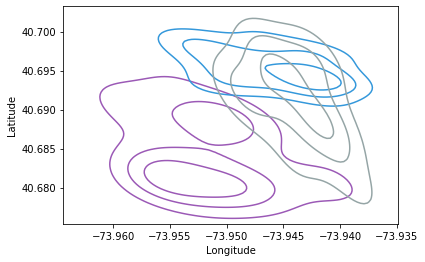

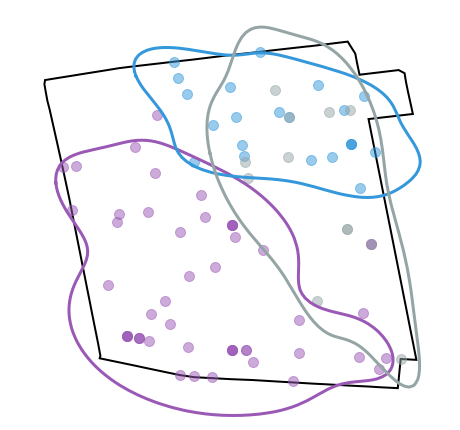

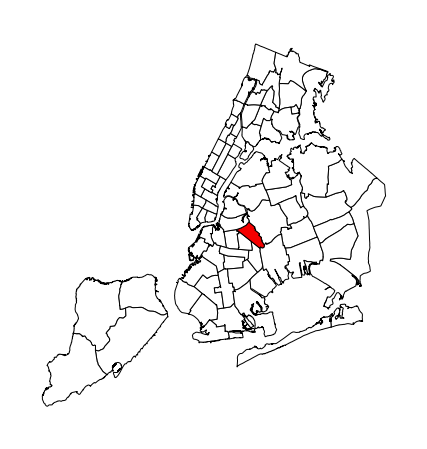

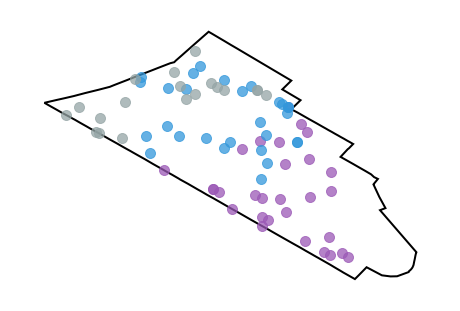

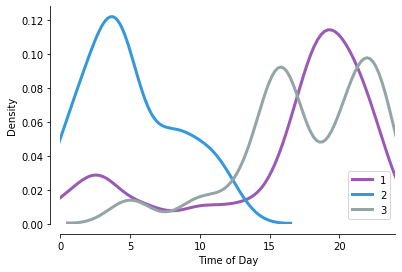

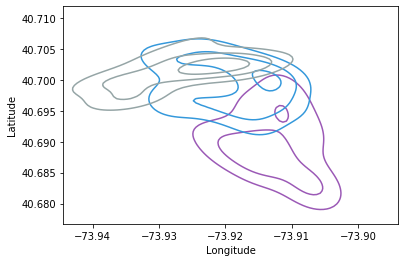

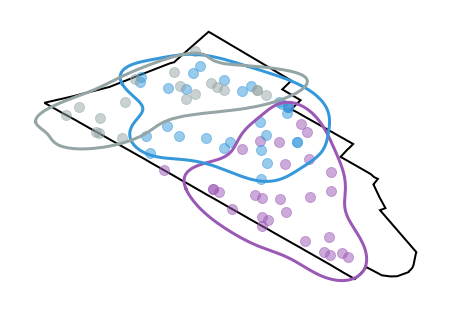

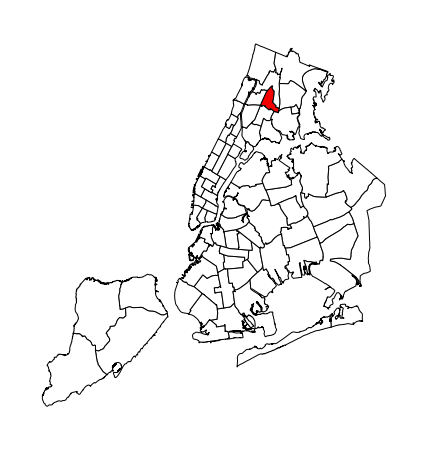

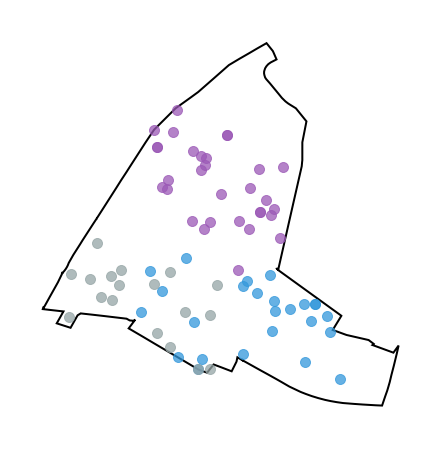

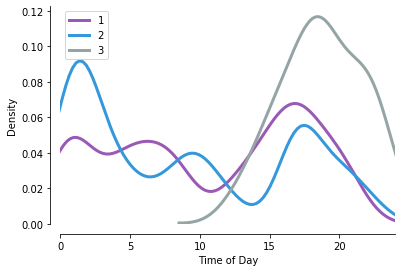

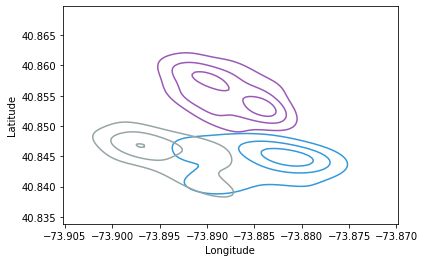

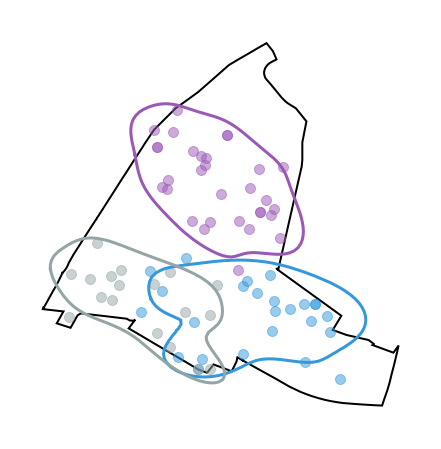

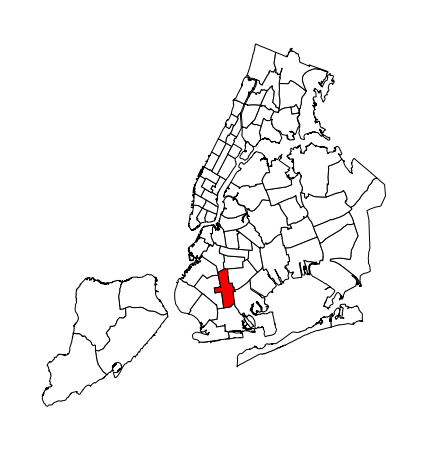

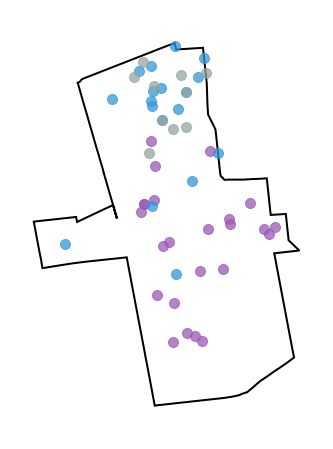

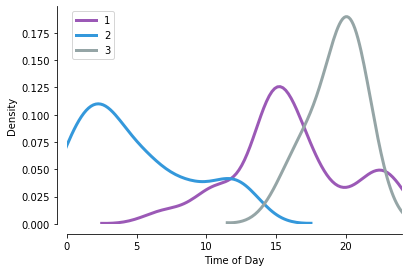

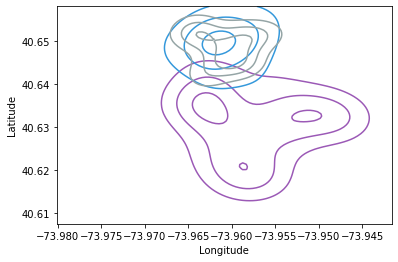

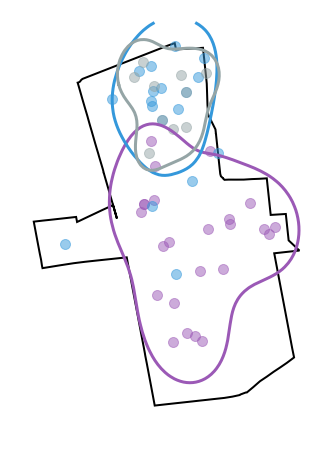

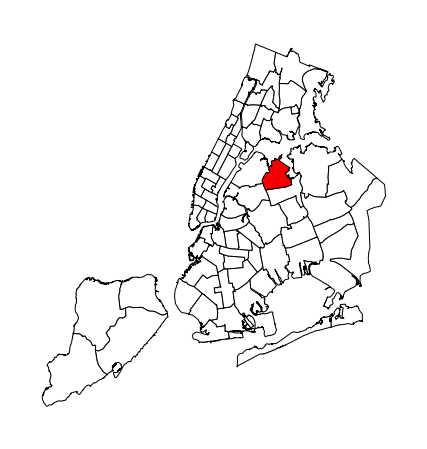

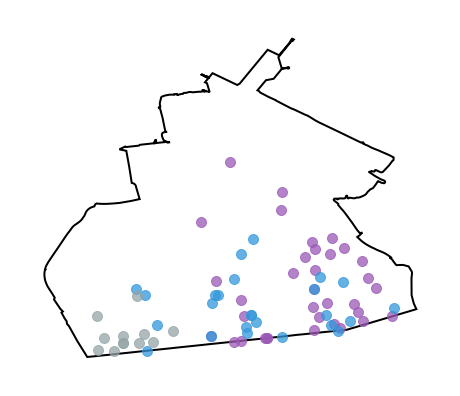

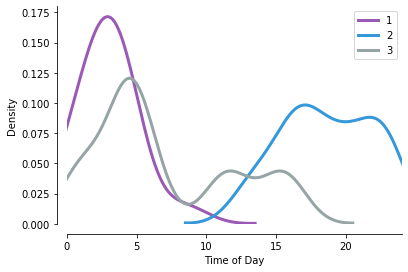

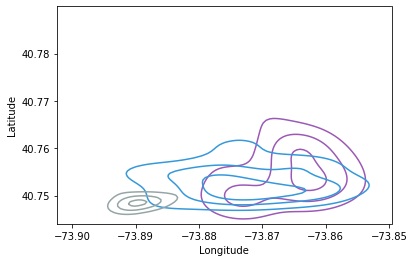

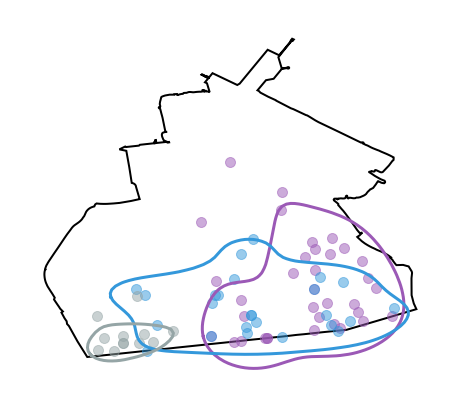

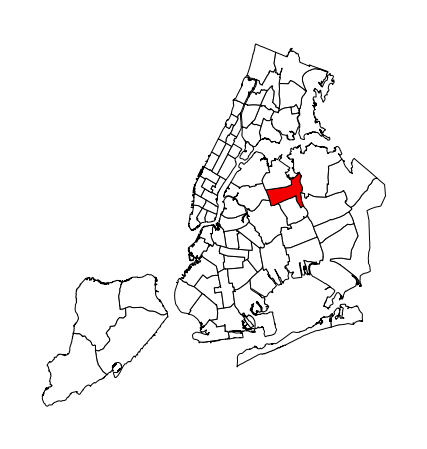

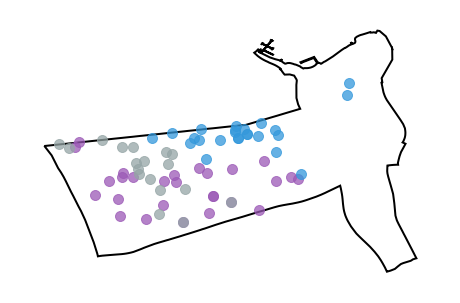

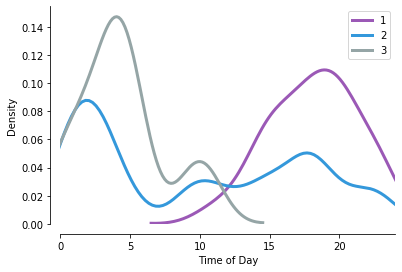

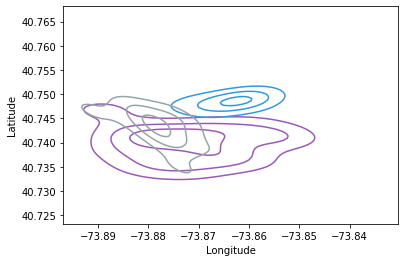

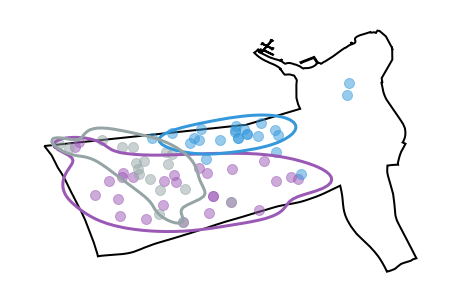

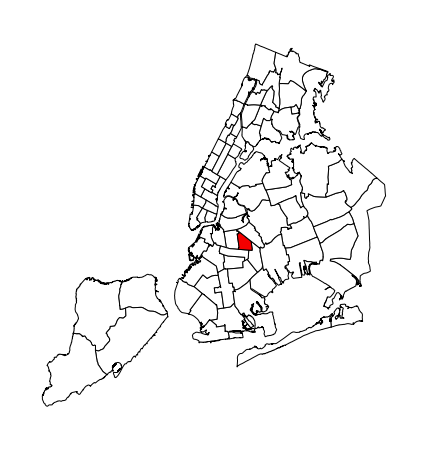

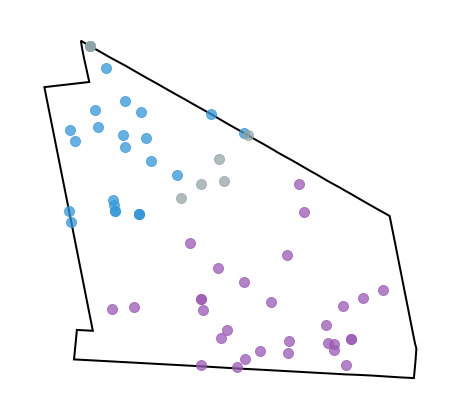

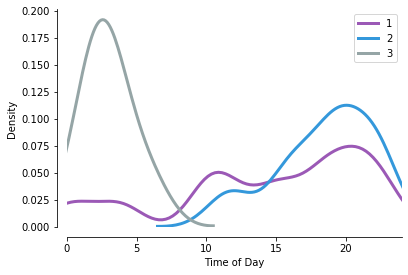

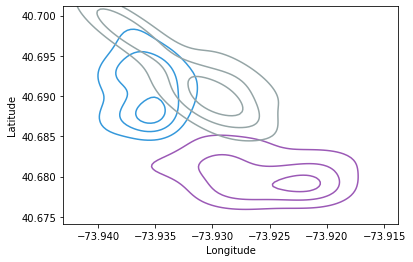

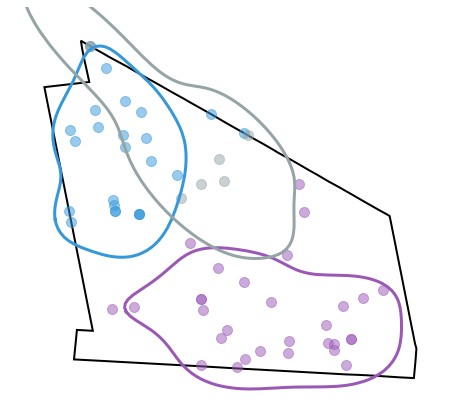

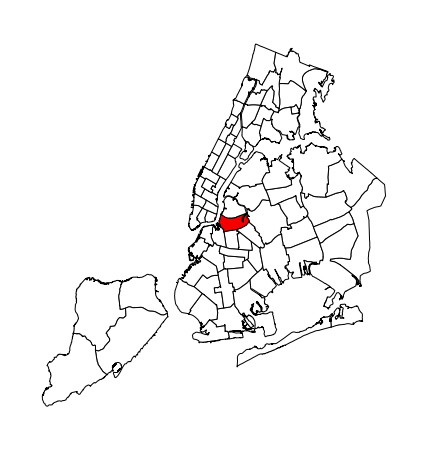

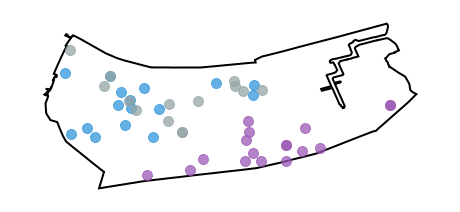

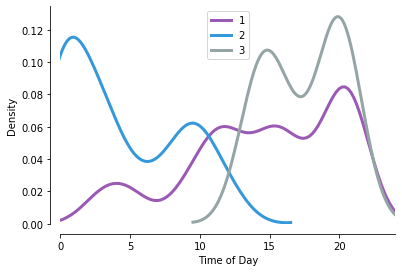

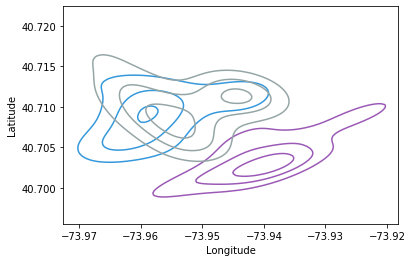

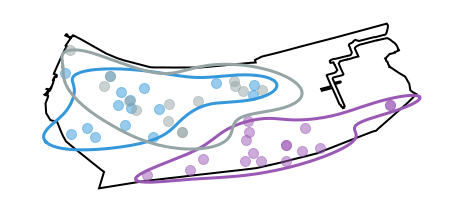

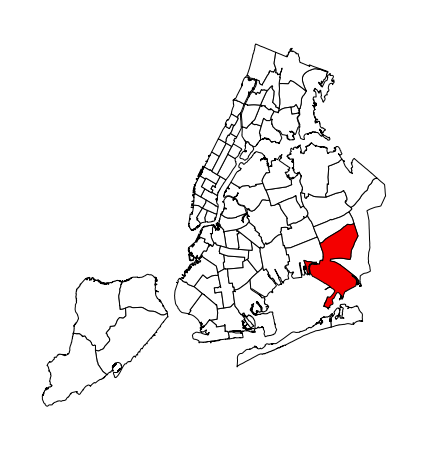

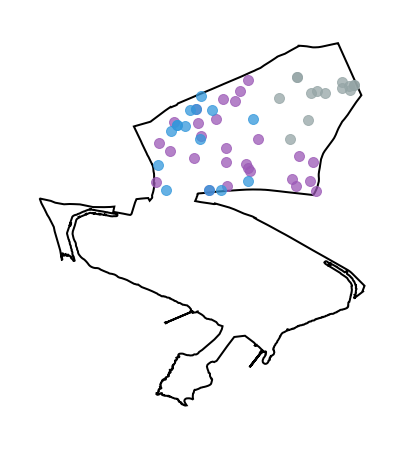

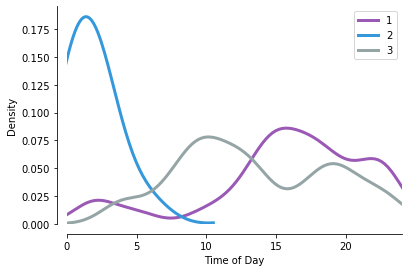

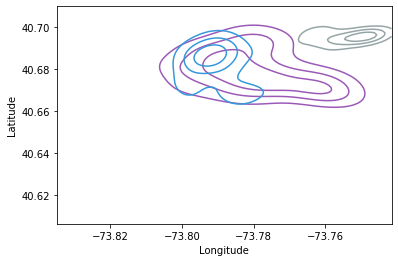

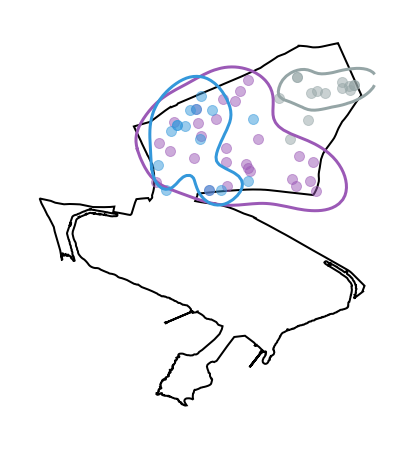

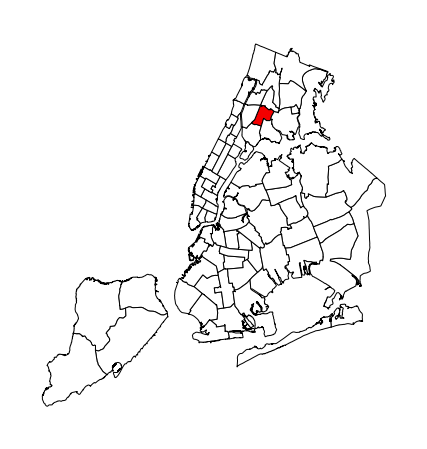

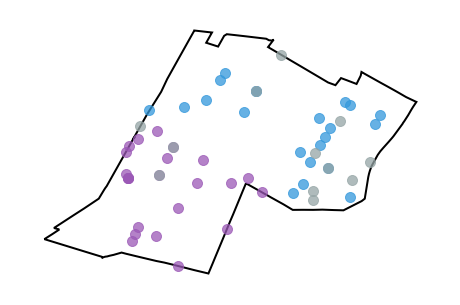

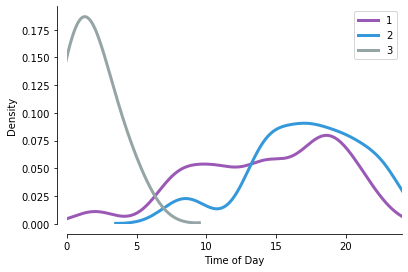

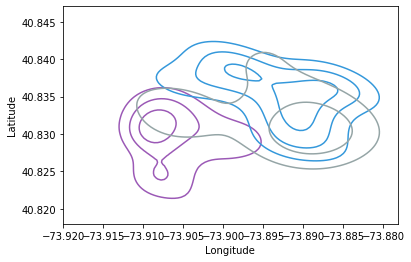

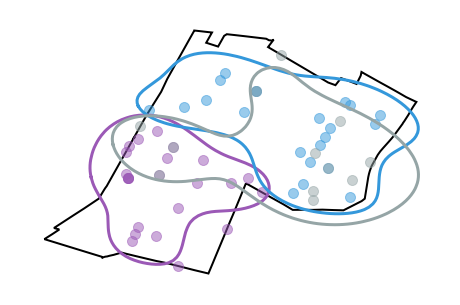

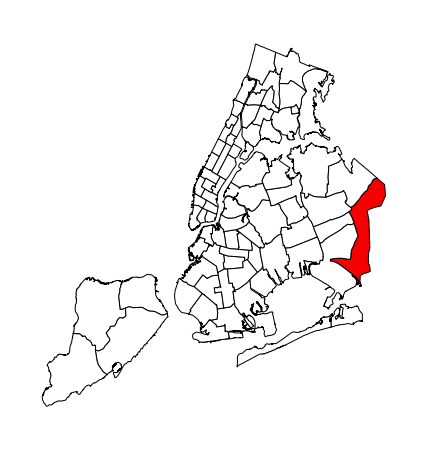

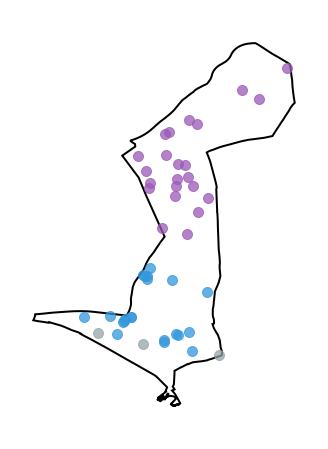

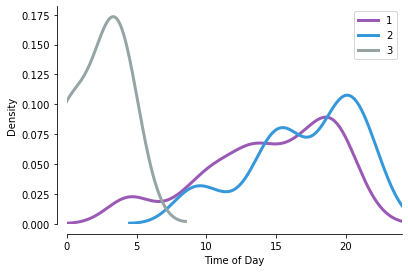

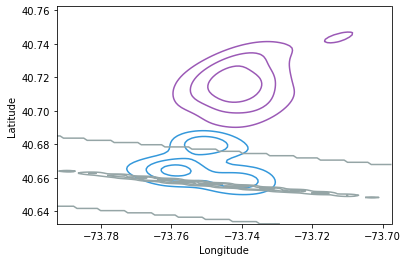

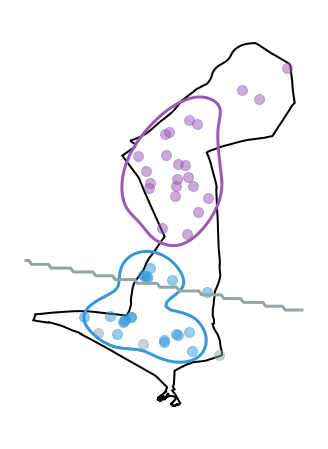

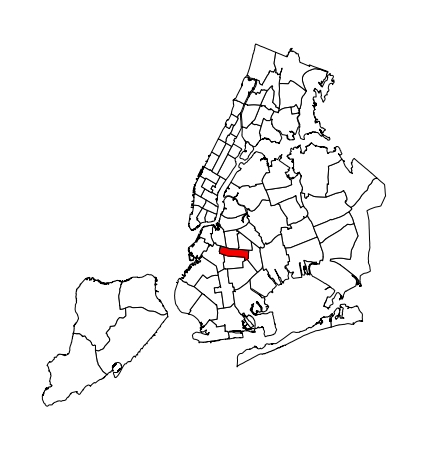

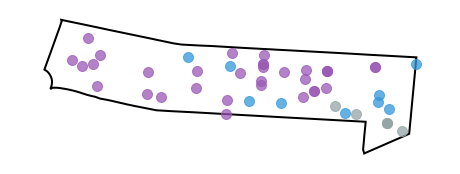

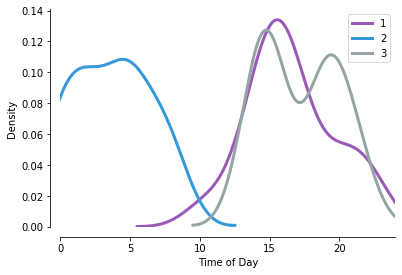

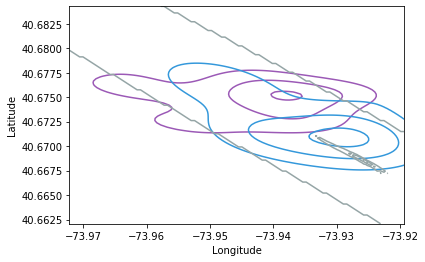

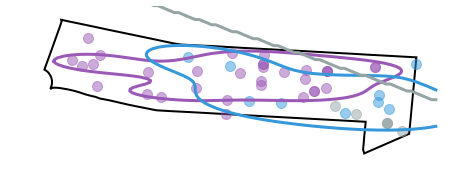

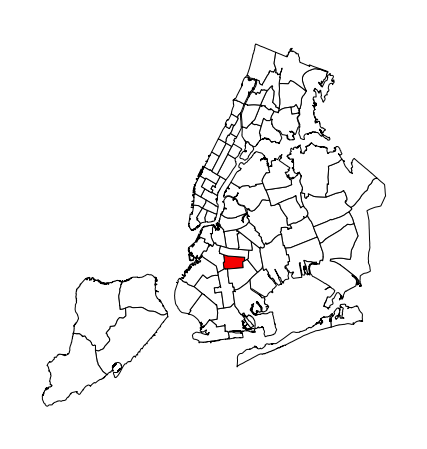

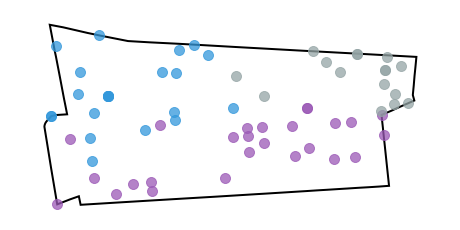

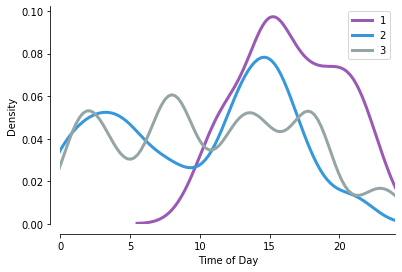

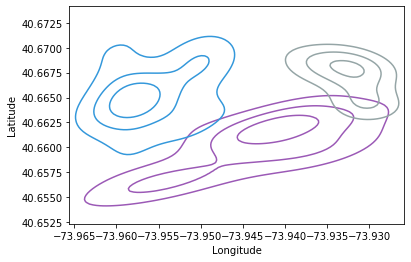

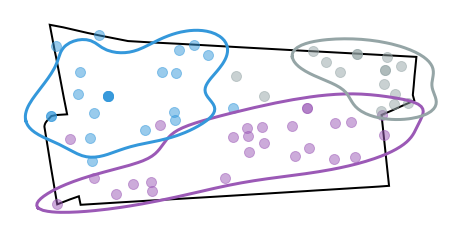

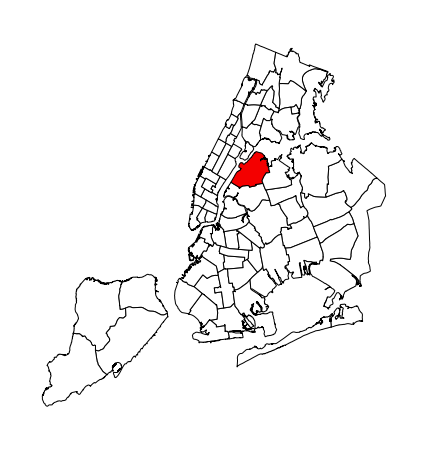

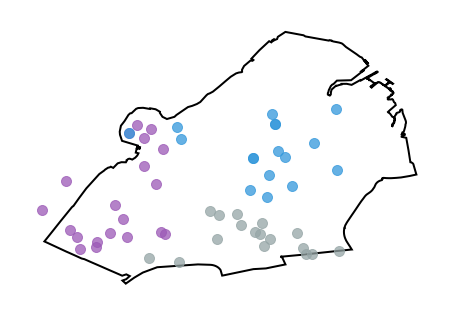

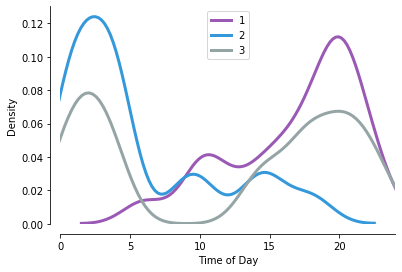

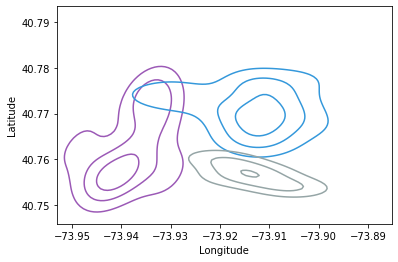

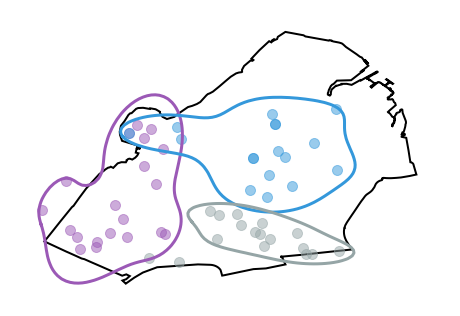

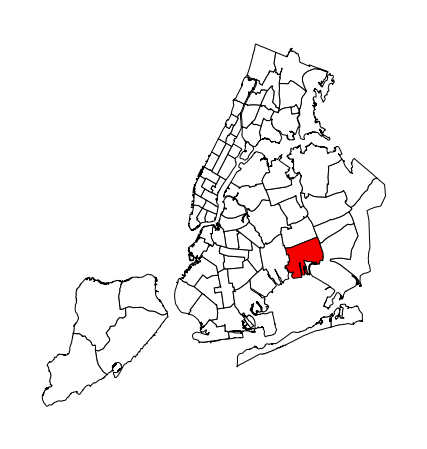

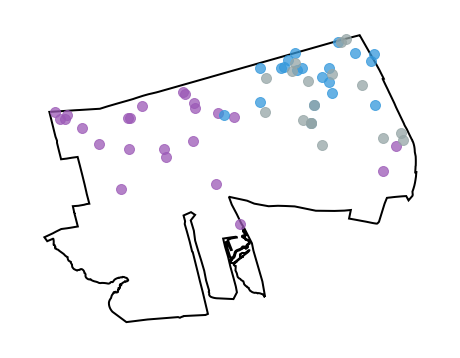

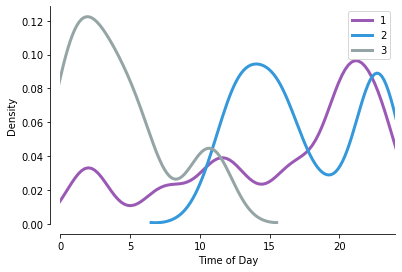

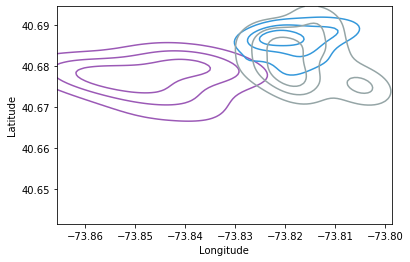

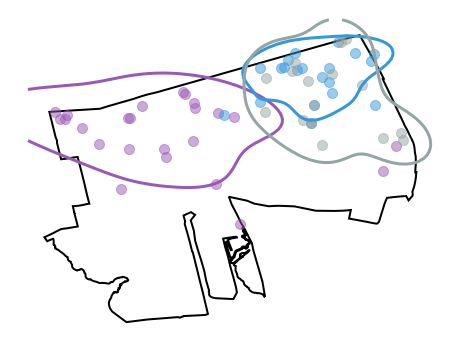

In [50]:
training_period = ['2017-10-01', '2017-12-31']
testing_period = ['2018-01-01', '2018-01-31']

n_clusters = 3
n_levels = 3

scores = []
for precinct in precincts:
    scores += [main(ds=ds, training_period=training_period, precinct=precinct, n_clusters=n_clusters, testing_period=testing_period, n_levels=n_levels)]

In [ ]:
print(np.mean(scores))
plt.hist(scores);
plt.xlim(0, 1)